# Machine Learning Engineer Nanodegree
## Supervised Learning
## Project: Building a Student Intervention System

Welcome to the second project of the Machine Learning Engineer Nanodegree! In this notebook, some template code has already been provided for you, and it will be your job to implement the additional functionality necessary to successfully complete this project. Sections that begin with **'Implementation'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section and the specifics of the implementation are marked in the code block with a `'TODO'` statement. Please be sure to read the instructions carefully!

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.  

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

### Question 1 - Classification vs. Regression
*Your goal for this project is to identify students who might need early intervention before they fail to graduate. Which type of supervised learning problem is this, classification or regression? Why?*

**Answer: **
This project is Supervised Classifier problem that because the output variable is class labels.
Classification is used to predict which class a data point is a part of (discrete value) which is binary classification
YES(Intervention) or NO (No need for Intervention)

As I mentioned, this problem is Supervised Classification. The Supervised Regression is trying to predict continuous values like the grade of a student (89.9%). Classification is used to predict which class a data point is a part of (discrete value) which is binary classification YES(1) or NO (0) in the case of Studen Intervention problem or Multiclass where classify the student into three or more groups like (Fail, Pass, and Exceed expectations).

## Exploring the Data
Run the code cell below to load necessary Python libraries and load the student data. Note that the last column from this dataset, `'passed'`, will be our target label (whether the student graduated or didn't graduate). All other columns are features about each student.

In [4]:
# Import libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from time import time
from sklearn.cross_validation import ShuffleSplit, train_test_split
from sklearn.metrics import make_scorer, f1_score
from sklearn.learning_curve import learning_curve
from sklearn.datasets import load_digits

# Read student data
student_data = pd.read_csv("student-data.csv")
print "Student data read successfully!"

Student data read successfully!


### Implementation: Data Exploration
Let's begin by investigating the dataset to determine how many students we have information on, and learn about the graduation rate among these students. In the code cell below, you will need to compute the following:
- The total number of students, `n_students`.
- The total number of features for each student, `n_features`.
- The number of those students who passed, `n_passed`.
- The number of those students who failed, `n_failed`.
- The graduation rate of the class, `grad_rate`, in percent (%).


In [5]:
# TODO: Calculate number of students
n_students = len(student_data)

# TODO: Calculate number of features
n_features = len(student_data.ix[:, student_data.columns != 'passed'].columns)

# TODO: Calculate passing students
n_passed = len(student_data[student_data['passed'] == 'yes'])

# TODO: Calculate failing students
n_failed = len(student_data[student_data['passed'] == 'no'])

# TODO: Calculate graduation rate
grad_rate = (float(n_passed)/float(n_students))* 100

grad_rate_failed = (float(n_failed)/float(n_students))* 100

# Print the results
print "Total number of students: {}".format(n_students)
print "Number of features: {}".format(n_features)
print "Number of students who passed: {}".format(n_passed)
print "Number of students who failed: {}".format(n_failed)
print "Graduation rate of the class: {:.2f}%".format(grad_rate)
print "Graduation rate of the class: {:.2f}%".format(grad_rate_failed)

Total number of students: 395
Number of features: 30
Number of students who passed: 265
Number of students who failed: 130
Graduation rate of the class: 67.09%
Graduation rate of the class: 32.91%


## Preparing the Data
In this section, we will prepare the data for modeling, training and testing.

### Identify feature and target columns
It is often the case that the data you obtain contains non-numeric features. This can be a problem, as most machine learning algorithms expect numeric data to perform computations with.

Run the code cell below to separate the student data into feature and target columns to see if any features are non-numeric.

In [3]:
# Extract feature columns
feature_cols = list(student_data.columns[:-1])

# Extract target column 'passed'
target_col = student_data.columns[-1] 

# Show the list of columns
print "Feature columns:\n{}".format(feature_cols)
print "\nTarget column: {}".format(target_col)

# Separate the data into feature data and target data (X_all and y_all, respectively)
X_all = student_data[feature_cols]
y_all = student_data[target_col]

# Show the feature information by printing the first five rows
print "\nFeature values:"
print X_all.head()

Feature columns:
['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']

Target column: passed

Feature values:
  school sex  age address famsize Pstatus  Medu  Fedu     Mjob      Fjob  \
0     GP   F   18       U     GT3       A     4     4  at_home   teacher   
1     GP   F   17       U     GT3       T     1     1  at_home     other   
2     GP   F   15       U     LE3       T     1     1  at_home     other   
3     GP   F   15       U     GT3       T     4     2   health  services   
4     GP   F   16       U     GT3       T     3     3    other     other   

    ...    higher internet  romantic  famrel  freetime goout Dalc Walc health  \
0   ...       yes       no        no       4         3     4    1    1      3   
1   ...       

### Preprocess Feature Columns

As you can see, there are several non-numeric columns that need to be converted! Many of them are simply `yes`/`no`, e.g. `internet`. These can be reasonably converted into `1`/`0` (binary) values.

Other columns, like `Mjob` and `Fjob`, have more than two values, and are known as _categorical variables_. The recommended way to handle such a column is to create as many columns as possible values (e.g. `Fjob_teacher`, `Fjob_other`, `Fjob_services`, etc.), and assign a `1` to one of them and `0` to all others.

These generated columns are sometimes called _dummy variables_, and we will use the [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) function to perform this transformation. Run the code cell below to perform the preprocessing routine discussed in this section.

In [4]:
def preprocess_features(X):
    ''' Preprocesses the student data and converts non-numeric binary variables into
        binary (0/1) variables. Converts categorical variables into dummy variables. '''
    
    # Initialize new output DataFrame
    output = pd.DataFrame(index = X.index)

    # Investigate each feature column for the data
    for col, col_data in X.iteritems():
        
        # If data type is non-numeric, replace all yes/no values with 1/0
        if col_data.dtype == object:
            col_data = col_data.replace(['yes', 'no'], [1, 0])

        # If data type is categorical, convert to dummy variables
        if col_data.dtype == object:
            # Example: 'school' => 'school_GP' and 'school_MS'
            col_data = pd.get_dummies(col_data, prefix = col)  
        
        # Collect the revised columns
        output = output.join(col_data)
    
    return output

X_all = preprocess_features(X_all)
print "Processed feature columns ({} total features):\n{}".format(len(X_all.columns), list(X_all.columns))

Processed feature columns (48 total features):
['school_GP', 'school_MS', 'sex_F', 'sex_M', 'age', 'address_R', 'address_U', 'famsize_GT3', 'famsize_LE3', 'Pstatus_A', 'Pstatus_T', 'Medu', 'Fedu', 'Mjob_at_home', 'Mjob_health', 'Mjob_other', 'Mjob_services', 'Mjob_teacher', 'Fjob_at_home', 'Fjob_health', 'Fjob_other', 'Fjob_services', 'Fjob_teacher', 'reason_course', 'reason_home', 'reason_other', 'reason_reputation', 'guardian_father', 'guardian_mother', 'guardian_other', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']


### Implementation: Training and Testing Data Split
So far, we have converted all _categorical_ features into numeric values. For the next step, we split the data (both features and corresponding labels) into training and test sets. In the following code cell below, you will need to implement the following:
- Randomly shuffle and split the data (`X_all`, `y_all`) into training and testing subsets.
  - Use 300 training points (approximately 75%) and 95 testing points (approximately 25%).
  - Set a `random_state` for the function(s) you use, if provided.
  - Store the results in `X_train`, `X_test`, `y_train`, and `y_test`.

In [5]:
# TODO: Import any additional functionality you may need here
from sklearn.cross_validation import train_test_split

# TODO: Set the number of training points
num_train = 300

# Set the number of testing points
num_test = X_all.shape[0] - num_train

# TODO: Shuffle and split the dataset into the number of training and testing points above

# X_train, X_test, y_train, y_test = train_test_split(\
#                      X_all, y_all,\
#                      train_size=num_train, test_size=num_test, random_state=13)

X_train, X_test, y_train, y_test = train_test_split(\
                     X_all, y_all,\
                     stratify=y_all,
                     train_size=num_train, test_size=num_test, random_state=13)

# Show the results of the split
print "Training set has {} samples.".format(X_train.shape[0])
print "Testing set has {} samples.".format(X_test.shape[0])

print 
print "Use stratify parameters to maintain the class imbalance across training and testing label data." 
print "Train set 'yes' pct = {:.2f}%".format(100 * (y_train == 'yes').mean())
print "Test  set 'yes' pct = {:.2f}%".format(100 * (y_test == 'yes').mean())

Training set has 300 samples.
Testing set has 95 samples.

Use stratify parameters to maintain the class imbalance across training and testing label data.
Train set 'yes' pct = 67.00%
Test  set 'yes' pct = 67.37%


## Training and Evaluating Models
In this section, you will choose 3 supervised learning models that are appropriate for this problem and available in `scikit-learn`. You will first discuss the reasoning behind choosing these three models by considering what you know about the data and each model's strengths and weaknesses. You will then fit the model to varying sizes of training data (100 data points, 200 data points, and 300 data points) and measure the F<sub>1</sub> score. You will need to produce three tables (one for each model) that shows the training set size, training time, prediction time, F<sub>1</sub> score on the training set, and F<sub>1</sub> score on the testing set.

**The following supervised learning models are currently available in** [`scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html) **that you may choose from:**
- Gaussian Naive Bayes (GaussianNB)
- Decision Trees
- Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)
- K-Nearest Neighbors (KNeighbors)
- Stochastic Gradient Descent (SGDC)
- Support Vector Machines (SVM)
- Logistic Regression

### Question 2 - Model Application
*List three supervised learning models that are appropriate for this problem. For each model chosen*
- Describe one real-world application in industry where the model can be applied. *(You may need to do a small bit of research for this — give references!)* 
- What are the strengths of the model; when does it perform well? 
- What are the weaknesses of the model; when does it perform poorly?
- What makes this model a good candidate for the problem, given what you know about the data?

**Answer: **
- **<font color='blue'>Support Vector Machines</font>**
    - *Where?*
        - <a href="http://bioinformatics.oxfordjournals.org/cgi/content/abstract/bti687v1">SVM for Protein Fold and Remote Homology Detection.</a>
          Homology among proteins or DNA is typically inferred from their sequence similarity. Use the SVC to determine the similarity between pairs of protein sequences.
    - *Strength*
        - It scales relatively well to high dimensional data
        - Tradeoff between classifier complexity and error can be controlled explicitly using a regularisation parameter.
        - It uses the kernel trick, so The model can capture very complex non-linear interactions in the data.
    - *Weaknesses*
        - Need a “good” kernel function because the kernel models can be quite sensitive to over-fitting
    - *Why?* SVM can capture non-linear interactions. Moreover, the classes in the given dataset are slightly imbalanced (67% vs 33%), so the class_weight paramteter may be helpful here. The dataset is also relatively small (395 rows), which is why the performance limitations of SVMs should not be too bad. Since we have a binary classification problem, SVM's limitation to binary classification is not a problem either.
    
- **<font color='blue'>Ensemble Adaboost Methods</font>**
    - *Where?*
        - <a href="https://www.ncbi.nlm.nih.gov/pubmed/27781951">AdaBoost with SVM based pathological brain detection in MRI scanning</a>. 
    - *Strength*
        - Predictive power
        - Combine different classification models to cancel out their individual weakness, which results stable and well-performing models
    - *Weaknesses*
        - Strength weak learner lead to overfit over the training data
        - Computation cost is high because Adaboost uses the complete training set to train the weak learners
    - *Why?*
        - The samples size less than 100K <a href="http://scikit-learn.org/0.17/tutorial/machine_learning_map/index.html">Refer</a>
        - The AdaBoost training process selects only those features known to 
            - improve the predictive power of the model,
            - reducing dimensionality 
            - and potentially improving execution time.
- **<font color='blue'>K-Nearest Neighbors</font>**
    - *Where?*
        - <a href="https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2243774/">K-nearest neighbors algorithm on breast cancer diagnosis problem.</a>
    - *Strength*
        - Robust to noisy training data by averaging k-nearest neighbors.
        - The training phase is pretty fast (Lazy Algorithm)
    - *Weaknesses*
        - Need to determine value of parameter K (number of nearest neighbors)
        - Distance based learning is not clear which type of distance to use and which attribute to use to produce the best results.
        - Computation cost is quite high because we need to compute distance of each query instance to all training samples.
        - Distance works naturally with numeric features so it is good to generalize and/or normalize the data.
        - The number of dimensions that will affect the Performance (curse of dimensionality)
    - *Why?*
        - The samples size less than 100K<a href="http://scikit-learn.org/0.17/tutorial/machine_learning_map/index.html">Refer</a>
        - The dataset is relatively small (395 rows), which is why the performance limitations of KNN should not be  bad. Also, the features number is not too large, which is mean KNN will not suffere from Curse of Dimensionality. The KNN has no model other than storing the entire dataset, so there is no learning required.

In [6]:
def train_classifier(clf, X_train, y_train):
    ''' Fits a classifier to the training data. '''
    
    # Start the clock, train the classifier, then stop the clock
    start = time()
    clf.fit(X_train, y_train)
    end = time()
    
    # Print the results
    print "Trained model in {:.4f} seconds".format(end - start)

    
def predict_labels(clf, features, target):
    ''' Makes predictions using a fit classifier based on F1 score. '''
    
    # Start the clock, make predictions, then stop the clock
    start = time()
    y_pred = clf.predict(features)
    end = time()
    
    # Print and return results
    print "Made predictions in {:.4f} seconds.".format(end - start)
    return f1_score(target.values, y_pred, pos_label='yes')


def train_predict(clf, X_train, y_train, X_test, y_test):
    ''' Train and predict using a classifer based on F1 score. '''
    
    # Indicate the classifier and the training set size
    print "Training a {} using a training set size of {}. . .".format(clf.__class__.__name__, len(X_train))
    
    # Train the classifier
    train_classifier(clf, X_train, y_train)
    
    # Print the results of prediction for both training and testing
    print "F1 score for training set: {:.4f}.".format(predict_labels(clf, X_train, y_train))
    print "F1 score for test set: {:.4f}.".format(predict_labels(clf, X_test, y_test))

In [7]:
print(__doc__)

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    
    plt.xlim([0, X.shape[0]*0.8])
    plt.ylim([-0.05, 1.05])
    
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    f1_scorer = make_scorer(f1_score, pos_label='yes')
    
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring=f1_scorer)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

Automatically created module for IPython interactive environment


### Implementation: Model Performance Metrics
With the predefined functions above, you will now import the three supervised learning models of your choice and run the `train_predict` function for each one. Remember that you will need to train and predict on each classifier for three different training set sizes: 100, 200, and 300. Hence, you should expect to have 9 different outputs below — 3 for each model using the varying training set sizes. In the following code cell, you will need to implement the following:
- Import the three supervised learning models you've discussed in the previous section.
- Initialize the three models and store them in `clf_A`, `clf_B`, and `clf_C`.
 - Use a `random_state` for each model you use, if provided.
 - **Note:** Use the default settings for each model — you will tune one specific model in a later section.
- Create the different training set sizes to be used to train each model.
 - *Do not reshuffle and resplit the data! The new training points should be drawn from `X_train` and `y_train`.*
- Fit each model with each training set size and make predictions on the test set (9 in total).  
**Note:** Three tables are provided after the following code cell which can be used to store your results.

In [8]:
# TODO: Import the three supervised learning models from sklearn
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier

# TODO: Initialize the three models
clf_A = SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,\
    decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',\
    max_iter=-1, probability=False, random_state=None, shrinking=True,\
    tol=0.001, verbose=False)
clf_B = AdaBoostClassifier(base_estimator=None, n_estimators=50, learning_rate=1.0,\
                           algorithm='SAMME.R', random_state=None)
clf_C = KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='auto',\
                             leaf_size=30, p=2, metric='minkowski', metric_params=None, n_jobs=1)

# TODO: Set up the training set sizes
# X_train, X_test, y_train, y_test
X_train_100 = X_train[:100]
y_train_100 = y_train[:100]

X_train_200 = X_train[:200]
y_train_200 = y_train[:200]

X_train_300 = X_train[:300]
y_train_300 = y_train[:300]


# TODO: Execute the 'train_predict' function for each classifier and each training set size
# train_predict(clf, X_train, y_train, X_test, y_test)
train_predict(clf_A, X_train_100, y_train_100, X_test, y_test)
print
train_predict(clf_A, X_train_200, y_train_200, X_test, y_test)
print
train_predict(clf_A, X_train_300, y_train_300, X_test, y_test)
print "-------------------------------------------------------------"
train_predict(clf_B, X_train_100, y_train_100, X_test, y_test)
print
train_predict(clf_B, X_train_200, y_train_200, X_test, y_test)
print
train_predict(clf_B, X_train_300, y_train_300, X_test, y_test)
print "-------------------------------------------------------------"
train_predict(clf_C, X_train_100, y_train_100, X_test, y_test)
print
train_predict(clf_C, X_train_200, y_train_200, X_test, y_test)
print
train_predict(clf_C, X_train_300, y_train_300, X_test, y_test)

Training a SVC using a training set size of 100. . .
Trained model in 0.0015 seconds
Made predictions in 0.0007 seconds.
F1 score for training set: 0.8608.
Made predictions in 0.0007 seconds.
F1 score for test set: 0.8077.

Training a SVC using a training set size of 200. . .
Trained model in 0.0032 seconds
Made predictions in 0.0021 seconds.
F1 score for training set: 0.8638.
Made predictions in 0.0012 seconds.
F1 score for test set: 0.8133.

Training a SVC using a training set size of 300. . .
Trained model in 0.0074 seconds
Made predictions in 0.0047 seconds.
F1 score for training set: 0.8621.
Made predictions in 0.0016 seconds.
F1 score for test set: 0.8212.
-------------------------------------------------------------
Training a AdaBoostClassifier using a training set size of 100. . .
Trained model in 0.0869 seconds
Made predictions in 0.0048 seconds.
F1 score for training set: 0.9784.
Made predictions in 0.0038 seconds.
F1 score for test set: 0.7407.

Training a AdaBoostClassifie

### Tabular Results
Edit the cell below to see how a table can be designed in [Markdown](https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet#tables). You can record your results from above in the tables provided.

** Classifer 1 - SVC**  

| Training Set Size | Training Time | Prediction Time (test) | F1 Score (train) | F1 Score (test) |
| :---------------: | :---------------------: | :--------------------: | :--------------: | :-------------: |
| 100               | 0.0016                  | 0.0007                 | 0.8608           | 0.8077          |
| 200               | 0.0043                  | 0.0012                 | 0.8638           | 0.8133          |
| 300               | 0.0072                  | 0.0019                 | 0.8621           | 0.8212          |

** Classifer 2 - AdaBoostClassifier**  

| Training Set Size | Training Time | Prediction Time (test) | F1 Score (train) | F1 Score (test) |
| :---------------: | :---------------------: | :--------------------: | :--------------: | :-------------: |
| 100               | 0.0874                  |  0.0042                | 0.9784           | 0.7407          |
| 200               | 0.0856                  |  0.0048                | 0.8809           | 0.7424          |
| 300               | 0.0910                  |  0.0073                | 0.8651           | 0.8029          |

** Classifer 3 - KNeighborsClassifier**  

| Training Set Size | Training Time | Prediction Time (test) | F1 Score (train) | F1 Score (test) |
| :---------------: | :---------------------: | :--------------------: | :--------------: | :-------------: |
| 100               |0.0004                   | 0.0009                 |  0.8113          | 0.8163          |
| 200               |0.0005                   | 0.0013                 |  0.8462          | 0.8112          |
| 300               |0.0007                   | 0.0018                 |  0.8604          | 0.8472          |

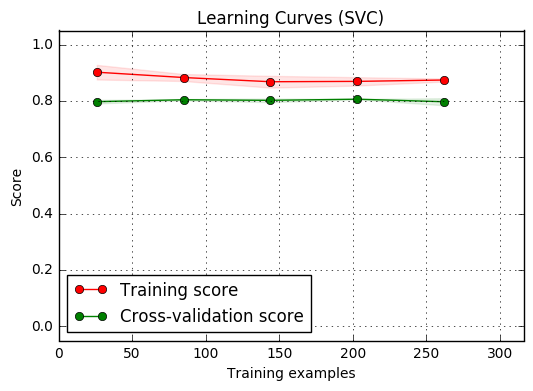

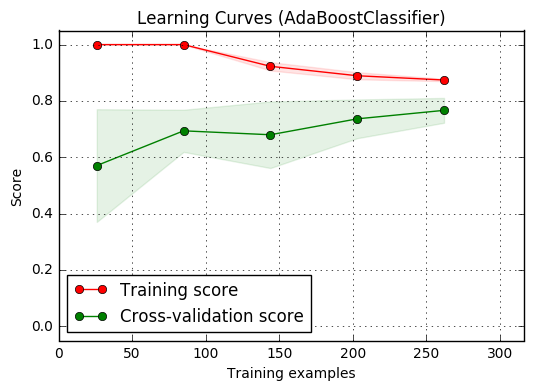

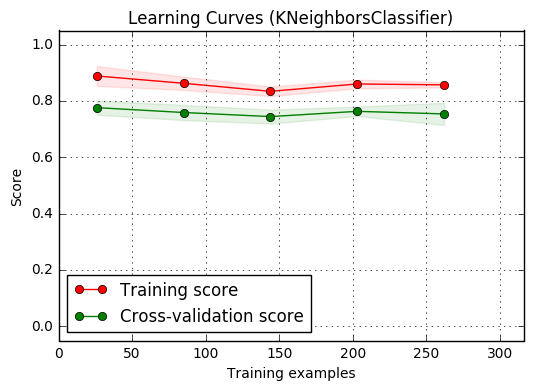

In [9]:
cv = ShuffleSplit(X_all.shape[0], n_iter = 10, test_size=num_test, random_state = 13)
title = "Learning Curves (SVC)"
plot_learning_curve(clf_A, title, X_all, y_all)
title = "Learning Curves (AdaBoostClassifier)"
plot_learning_curve(clf_B, title, X_all, y_all)
title = "Learning Curves (KNeighborsClassifier)"
plot_learning_curve(clf_C, title, X_all, y_all)
plt.show()

## Choosing the Best Model
In this final section, you will choose from the three supervised learning models the *best* model to use on the student data. You will then perform a grid search optimization for the model over the entire training set (`X_train` and `y_train`) by tuning at least one parameter to improve upon the untuned model's F<sub>1</sub> score. 

### Question 3 - Choosing the Best Model
*Based on the experiments you performed earlier, in one to two paragraphs, explain to the board of supervisors what single model you chose as the best model. Which model is generally the most appropriate based on the available data, limited resources, cost, and performance?*

**Answer: **
I recommend the KNeighborsClassifier model. The preliminary experiments confirm that it is in fact one of the fastest models (in terms of both training (0.0007) and prediction time (0.0018)). When using it, you will save valuable milliseconds of CPU time.
Moreover, the KNeighborsClassifier also seems to be the most effective of all tested models. The F1 score on the training (0.8604) and testing (0.8472) set is higest, suggesting that it will perform best on future students. In addition, the spread between F1 scores on train and test set are lowest. This is an indicator that the model is not overfitting to the small training set. Based on provided graph; the model is generalize and will be able to predict if the student need intervension with small margin of error.

### Question 4 - Model in Layman's Terms
*In one to two paragraphs, explain to the board of directors in layman's terms how the final model chosen is supposed to work. Be sure that you are describing the major qualities of the model, such as how the model is trained and how the model makes a prediction. Avoid using advanced mathematical or technical jargon, such as describing equations or discussing the algorithm implementation.*

**Answer: **
The selected model will predict weather a student will need intervention or not. We will take advantage of provided previous students data (sample data) and their graduation results to learn the model how to predict.

** How the model work? ** When we want to identify students who might need early intervention before they fail to graduate, we look at student's closest (most similar) neighbors, and we classify the student as the majority class in those neighbors.

The model depends on two things: Firstly, Looking for closest (most similar) students (Neighbors) and secondly, the number of closet students to consider (k)

When "k" is a small number, the model will classify just based on the closest students (neighbors) instead of learning a good separating frontier between the students who might need intervention or not need intervention. But if "k" is a big number the model will think every student belongs to the class that has more samples.

One nice advantage of KNN is that it can work fine if you only have a few samples (students) for some of the classes.

### Implementation: Model Tuning
Fine tune the chosen model. Use grid search (`GridSearchCV`) with at least one important parameter tuned with at least 3 different values. You will need to use the entire training set for this. In the code cell below, you will need to implement the following:
- Import [`sklearn.grid_search.GridSearchCV`](http://scikit-learn.org/0.17/modules/generated/sklearn.grid_search.GridSearchCV.html) and [`sklearn.metrics.make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html).
- Create a dictionary of parameters you wish to tune for the chosen model.
 - Example: `parameters = {'parameter' : [list of values]}`.
- Initialize the classifier you've chosen and store it in `clf`.
- Create the F<sub>1</sub> scoring function using `make_scorer` and store it in `f1_scorer`.
 - Set the `pos_label` parameter to the correct value!
- Perform grid search on the classifier `clf` using `f1_scorer` as the scoring method, and store it in `grid_obj`.
- Fit the grid search object to the training data (`X_train`, `y_train`), and store it in `grid_obj`.

-------------------------------------------------------------------
Made predictions in 0.0051 seconds.
KNN: Tuned model has a training F1 score of 0.8559.
Made predictions in 0.0020 seconds.
KNN: Tuned model has a testing F1 score of 0.8299.
-------------------------------------------------------------------
Best Parameters KNN
{'n_neighbors': 7, 'metric': 'euclidean', 'weights': 'uniform'}
-------------------------------------------------------------------
CV Validation Score KNN
[ 0.72131148  0.68656716  0.76712329]
-------------------------------------------------------------------
Mean Validation Score KNN
0.72500064242


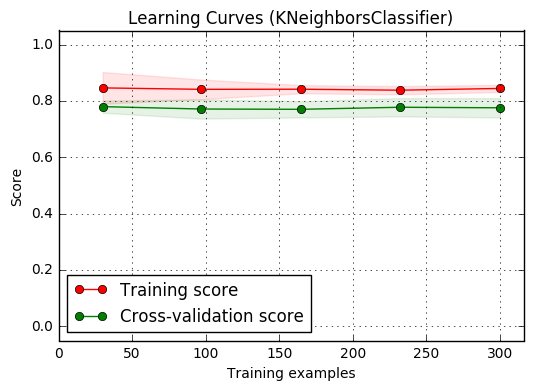

In [10]:
from sklearn.grid_search import GridSearchCV 

# TODO: Create the parameters list you wish to tune
k_range = list(range(1, 50))
metric_options = ["euclidean", "cityblock"]
weight_options = ['uniform', 'distance']
algorithm_options = ['auto', 'ball_tree', 'kd_tree', 'brute']
p_range = list(range(1, 3))
parametersKNN = {"n_neighbors": k_range, "metric": metric_options, "weights": weight_options}


#Cs = [0.001, 0.01, 0.1, 1., 10.]
#kernels = ['linear', 'poly', 'rbf', 'sigmoid']
#gammas = [0.001, 0.01, 0.032, 0.1, 1]
#parametersSVC = {'C': Cs, 'kernel': kernels}

# TODO: Initialize the classifier
clfKNN = KNeighborsClassifier()
#clfSVC = SVC()

# TODO: Make an f1 scoring function using 'make_scorer' 
f1_scorer = make_scorer(f1_score, pos_label='yes')

# TODO: Perform grid search on the classifier using the f1_scorer as the scoring method
grid_obj_KNN = GridSearchCV(clfKNN, parametersKNN, scoring=f1_scorer)
#grid_obj_SVC = GridSearchCV(clfSVC, parametersSVC, scoring=f1_scorer)

# TODO: Fit the grid search object to the training data and find the optimal parameters
grid_obj_KNN = grid_obj_KNN.fit(X_train, y_train)
#grid_obj_SVC = grid_obj_SVC.fit(X_train, y_train)

# Get the estimator
clfKNN = grid_obj_KNN.best_estimator_
#clfSVC = grid_obj_SVC.best_estimator_

# Report the final F1 score for training and testing after parameter tuning
print "-------------------------------------------------------------------"
print "KNN: Tuned model has a training F1 score of {:.4f}.".format(predict_labels(clfKNN, X_train, y_train))
print "KNN: Tuned model has a testing F1 score of {:.4f}.".format(predict_labels(clfKNN, X_test, y_test))
#print
#print "SVC: Tuned model has a training F1 score of {:.4f}.".format(predict_labels(clfSVC, X_train, y_train))
#print "SVC: Tuned model has a testing F1 score of {:.4f}.".format(predict_labels(clfSVC, X_test, y_test))

print "-------------------------------------------------------------------"
print 'Best Parameters KNN'
print grid_obj_KNN.best_params_
#print
#print 'Best Parameters SVC'
#print grid_obj_SVC.best_params_

# Array of 10 accuracy scores during 10-fold cv using the parameters
print "-------------------------------------------------------------------"
print 'CV Validation Score KNN'
print grid_obj_KNN.grid_scores_[0].cv_validation_scores
#print
#print 'CV Validation Score SVC'
#print grid_obj_SVC.grid_scores_[0].cv_validation_scores

# Mean of the 10 scores
print "-------------------------------------------------------------------"
print 'Mean Validation Score KNN'
print grid_obj_KNN.grid_scores_[0].mean_validation_score
#print
#print 'Mean Validation Score SVC'
#print grid_obj_SVC.grid_scores_[0].mean_validation_score

cv = ShuffleSplit(X_all.shape[0], n_iter = 10, test_size=num_test, random_state = 13)
title = "Learning Curves (KNeighborsClassifier)"
plot_learning_curve(clfKNN, title, X_all, y_all, cv=cv)
plt.show()

# title = "Learning Curves (SVC)"
# plot_learning_curve(clfSVC, title, X_all, y_all, cv=cv)
# plt.show()


### Question 5 - Final F<sub>1</sub> Score
*What is the final model's F<sub>1</sub> score for training and testing? How does that score compare to the untuned model?*

**Answer: **
    - Tuned model has a training F1 score of 0.8559.
    - Tuned model has a testing F1 score of 0.8299.
    
It seems the converge between F1 Score of Training and Testing before Tuning the parametrs is better by 0.0132. Also the training and prediction time are increased after tuning the classifier.

** Classifer 3 - KNeighborsClassifier**  

| Training Set Size | Training Time | Prediction Time (test) | F1 Score (train) | F1 Score (test) |
| :---------------: | :---------------------: | :--------------------: | :--------------: | :-------------: |
| 100               |0.0004                   | 0.0009                 |  0.8113          | 0.8163          |
| 200               |0.0005                   | 0.0013                 |  0.8462          | 0.8112          |
| 300               |0.0007                   | 0.0018                 |  0.8604          | 0.8472          |

In general, The learning curve on Tuned classifier looks good and Training and validation data converged.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.